In [3]:
# all libraries used in this notebook
import sys
import os.path
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# sorting function for files and directories

def sort_key_func(file_name):
        numbers = re.findall(r'\d+', file_name)
        if numbers:
            return int(numbers[0])
        return file_name

In [5]:
# import data from selected dataset

cwd = str(Path.cwd())
parent_dir = os.path.dirname(cwd)
audio_datasets_main_dir = "01_Dataset/01_audioDatasets"
audio_datasets_main_dir = os.path.join(parent_dir, audio_datasets_main_dir)

audio_datasets = []
if os.path.exists(audio_datasets_main_dir):
    for i in os.listdir(audio_datasets_main_dir):
        #if folder name does not start with a dot
        if i[0] != ".": 
            audio_datasets.append(i)
    audio_datasets = sorted(audio_datasets)
else:
    print("Audio dataset directory does not exist")

print(audio_datasets)

['01_ethernet_without_additional_noise', '02_ethernet_with_additional_noise', '03_kombination_1_without_additional_noise', '04_kombination_1_with_additional_noise', '05_kombination_2_without_additional_noise', '06_kombination_2_with_additional_noise', '07_noise_samples', 'voice_memo_loc_mac.txt']


In [6]:
# load noise samples

dataset_num_noise = 6 # noise dataset

spec_chunks_noise = None
spec_chunk_labels_noise = None

dataset_dir_noise = os.path.join(audio_datasets_main_dir, audio_datasets[dataset_num_noise])
file_list_noise = [f for f in os.listdir(dataset_dir_noise) if f.endswith('.npz')]

print(file_list_noise)
if len(file_list_noise) == 0:
    print(f"No npz file in the directory")
else:
    for file in file_list_noise:
        file_fullpath = os.path.join(dataset_dir_noise, file)
        print(file_fullpath)

        data = np.load(file_fullpath)

        if spec_chunks_noise is None:
            spec_chunks_noise = data['spec_chunks']
            spec_chunk_labels_noise = data['labels']
        else:
            spec_chunks_noise = np.concatenate((spec_chunks_noise, data['spec_chunks']), axis=0)
            spec_chunk_labels_noise = np.concatenate((spec_chunk_labels_noise, data['labels']), axis=0)


print(len(spec_chunks_noise))
print(f"positive samples: {np.count_nonzero(spec_chunk_labels_noise == 1)}")

print(np.max(spec_chunks_noise))
print(np.min(spec_chunks_noise))

['noise_dataset.npz']
/Users/mateseidl/Library/CloudStorage/OneDrive-SZTAKI/_SZTAKI/03_Masters_thesis/01_TUM_Masterarbeit_Ausarbeitung/07_Click_event_detection_software/01_Electrical_Connector_Click-Event_Detection_git_repo/01_Dataset/01_audioDatasets/07_noise_samples/noise_dataset.npz
1192
positive samples: 0
0.0
-120.0


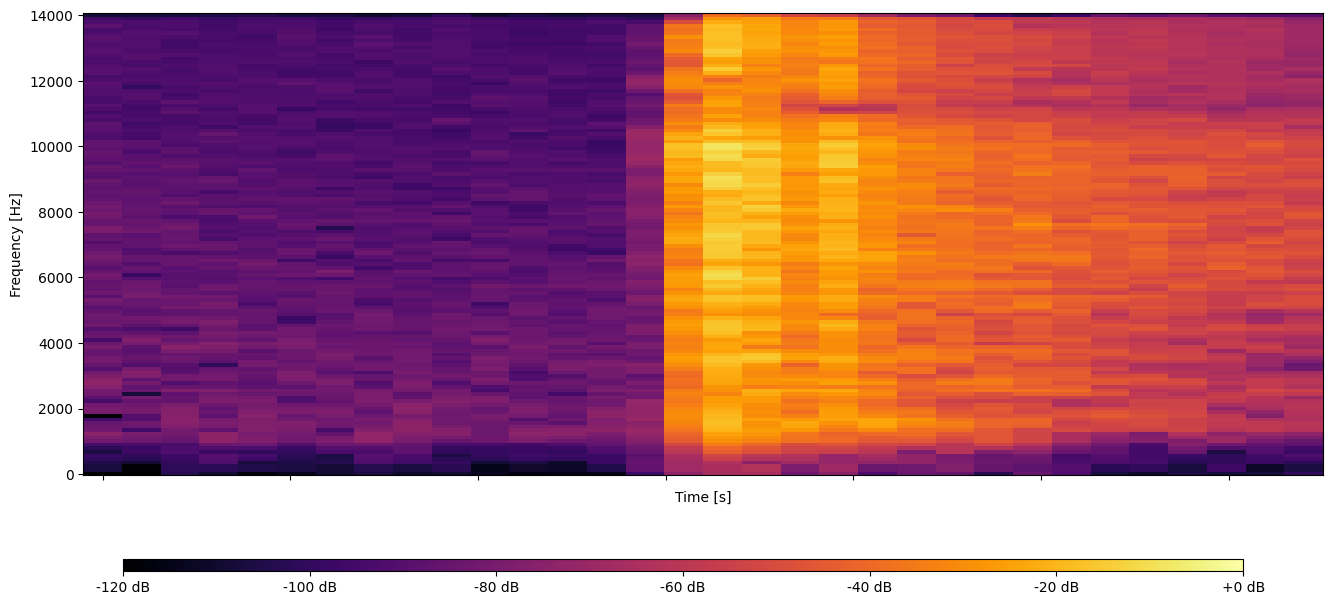

In [7]:
# plot a click mel spectrogram

chunk_id_to_plot = 1

top_dB_abs = 120
f_min = 20
f_max = 14000
n_mels = 128

def plot_mel_spectrogram(D_mel_dB, top_dB_abs, f_min, f_max, n_mels):

    fig_x = 16
    fig_y = 6
    fig, ax = plt.subplots(1, 1, figsize=(fig_x, fig_y))

    ax = plt.subplot()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.axes.xaxis.set_ticklabels([]) 
    mel_spec_img = ax.pcolormesh(np.linspace(0, D_mel_dB.shape[1], D_mel_dB.shape[1]),
                                            np.linspace(f_min, f_max, n_mels), 
                                            D_mel_dB, shading='auto', cmap='inferno')

    #mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=dB_ref)
    mel_spec_img.set_clim(vmin=-top_dB_abs, vmax=0)

    cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.02])
    fig.colorbar(mel_spec_img, cax=cbar_ax, orientation='horizontal', format="%+2.0f dB")

    plt.show()

noise_chunk_id_to_plot = 2

plot_mel_spectrogram(spec_chunks_noise[noise_chunk_id_to_plot], top_dB_abs, f_min, f_max, n_mels)